# 3.2 线性回归的从零开始实现

In [8]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.10.1+cpu


## 3.2.1 生成数据集

In [9]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
torch.manual_seed(100)
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [10]:
print(features[0], labels[0])

tensor([0.1268, 1.3564]) tensor(-0.1491)


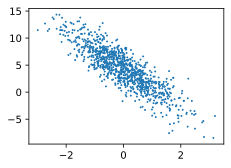

In [11]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

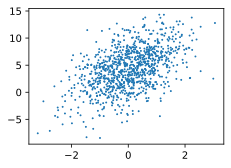

In [5]:
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1);

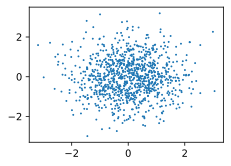

In [6]:
plt.scatter(features[:, 0].numpy(), features[:, 1].numpy(), 1);

In [7]:
from mpl_toolkits.mplot3d import Axes3D  #3D图表需要使用“mpl_toolkits”模块

In [ ]:
fig = plt.figure('3D scatter plot')
ax = fig.add_subplot(111, projection='3d')  #3d图需要加projection='3d'
ax.scatter(features[:, 0].numpy(), features[:, 1], labels.numpy(), c='r', marker='.')  #上半部分为红色圆点

## 3.2.2 读取数据

In [12]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [16]:
type(data_iter(10, features, labels))

generator

In [13]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # 循环里面只看一个的技巧

tensor([[ 0.7267, -1.7083],
        [ 0.9959, -0.1608],
        [ 0.5873,  1.1198],
        [-0.3461, -1.7266],
        [-0.5495, -0.7754],
        [ 2.5498,  1.5918],
        [ 0.4257,  0.9914],
        [ 1.0187,  0.4234],
        [ 0.9615, -0.2730],
        [ 0.2624, -0.5381]]) 
 tensor([11.4522,  6.7344,  1.5812,  9.3512,  5.7318,  3.8906,  1.6730,  4.8050,
         7.0581,  6.5555])


## 3.2.3 初始化模型参数

In [17]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [18]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

In [19]:
print(w, b)

tensor([[-0.0051],
        [-0.0043]], requires_grad=True) tensor([0.], requires_grad=True)


## 3.2.4 定义模型

In [20]:
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [21]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [29]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        # param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data
        # 计算图中的叶子节点不能直接进行内置运算，防止影响计算图的反向传播运算。
        # 如果非要改变叶子节点data的值，可以直接对data属性调用内置运算，
        # 这样不会记录在计算图当中，或者使用detach()方法，因为返回的tensor共享data。
        # param -= lr * param.grad / batch_size # 注意这里更改param
        temp = param.detach()
        temp -= lr * param.grad / batch_size # 注意这里更改param时用的param.detach() 
        # param.detach() -= lr * param.grad / batch_size # can't assign to function call

## 3.2.7 训练模型

In [30]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.000054
epoch 2, loss 0.000054
epoch 3, loss 0.000054


In [27]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9995],
        [-3.3988]], requires_grad=True)
4.2 
 tensor([4.2004], requires_grad=True)
